**Time series analysis** comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data.  
**Time series forecasting** is the use of a model to predict future values based on previously observed values.  
   
Time series are widely used for **non-stationary** data, like economic, weather, stock price, and retail sales in this post. We will demonstrate different approaches for forecasting retail sales time series. Let's get started !!!  


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## ***Data***

There are several categories in the Superstore sale data, we start from time series analysis and forecasting for furniture sales

In [2]:
df = pd.read_excel("/content/Sample - Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


We have a good 4-year furniture sales data

In [3]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

## ***Data Preprocessing***  
This step includes removing columns we don't need, check missing values, aggregate sales by date and so on.

In [4]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 
        'Customer ID', 'Customer Name', 'Segment', 'Country',
        'City', 'State', 'Postal Code', 'Region', 'Product ID', 
        'Category', 'Sub-Category', 'Product Name', 'Quantity', 
        'Discount', 'Profit']

furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

furniture.isnull().sum()


Order Date    0
Sales         0
dtype: int64

In [5]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

## ***Indexing with Time Series Data***

In [6]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp

In [7]:
y = furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 furnitures sales data

In [8]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## ***Visualizing Furniture Sales Time Series Data***

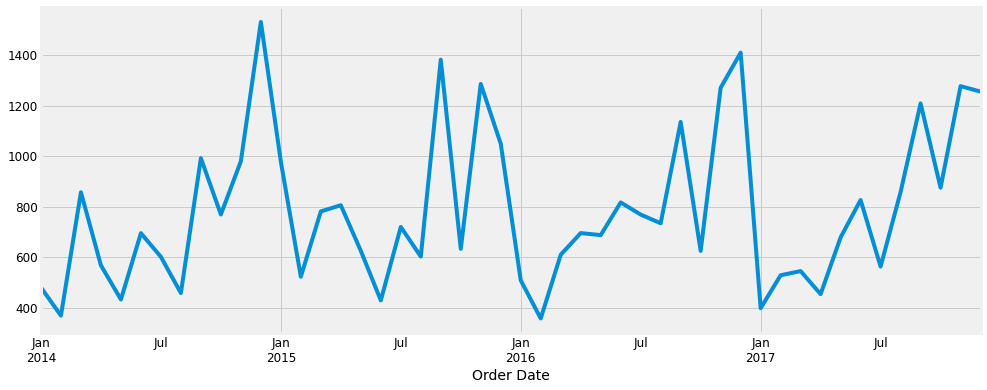

In [9]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of year. There is always an upward trend within any single year with a couple of low months in the mid of the year.  
   
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: Trend, Seasonality and Noise.  

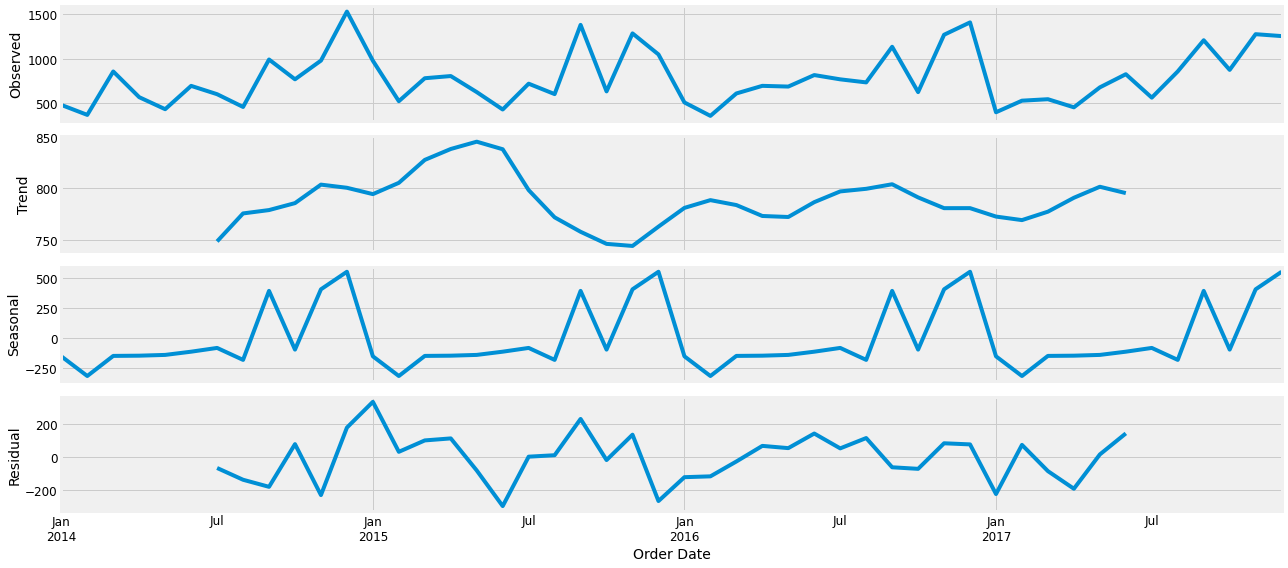

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.  


## ***Time Series forecasting with ARIMA***  
We are going to apply one of the most commonly used method for time-series forcasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.  
   
ARIMA models are denoted with the notation `ARIMA(p, d, q)`. These three parameters account for seasonality, trend, and noise in data:  

In [11]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMA: {} x {}'.format (pdq[1], seasonal_pdq[1]))
print('SARIMA: {} x {}'.format (pdq[1], seasonal_pdq[2]))
print('SARIMA: {} x {}'.format (pdq[2], seasonal_pdq[3]))
print('SARIMA: {} x {}'.format (pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 0, 1) x (0, 1, 0, 12)
SARIMA: (0, 1, 0) x (0, 1, 1, 12)
SARIMA: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture's sales ARIMA Time Series Model. Our goal here is to use a "grid search" to find the optimal set of parameters that yields the best performance for our model.

In [12]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1291.1586461285508
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1341.4774825752884
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758116
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2890.3956414293407
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809134


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5815754980983
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2592.49103021319
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468657
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1354.9157815720205
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.6378567198382
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1006.8019521666
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817193
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2534.1807038393567
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482836
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977442613
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2359.5912392244145
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417338
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1450.898321496226
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935194
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1262.338613078044
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084582
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442185634
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2665.6367167733683
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195815885
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323876976
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2536.9149846409973


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.01560020902036
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1508.5821409861014
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.20034222811347
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658784957


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1331.2919470409036
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345411
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835603


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2537.4523401808897
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.47626876093364
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.5250354660756


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439533909


The above output suggests that `SARIMAX(1,1,1)x(1,1,0,12)` yields the lowest `AIC` value of 297.78. Therefore we should consider this to be optimal option.  

## ***Fitting the ARIMA model***

In [13]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,0, 12),
                              enforce_stationarity = False, 
                              enforce_invertibility = False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


We should always run model diagnostics to investigate any unusual behavior.  

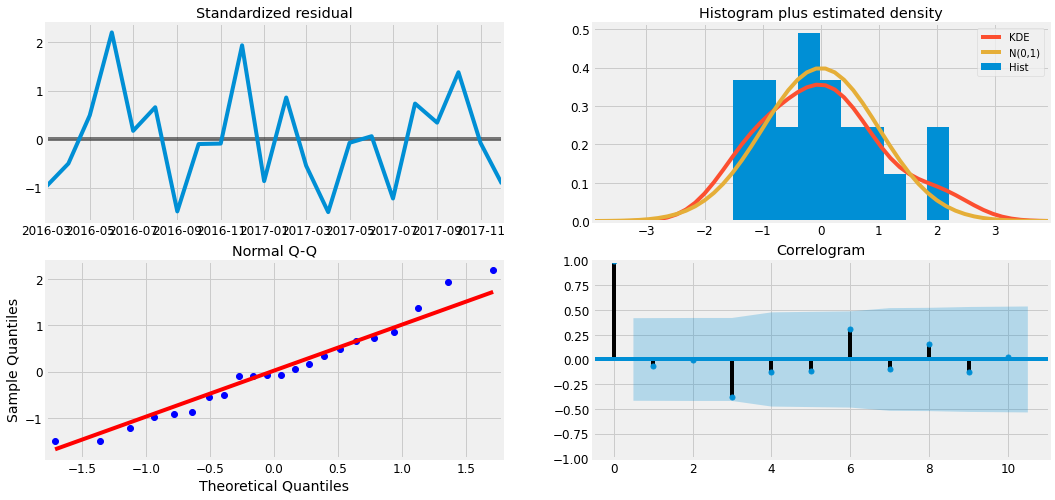

In [14]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed

## ***Validating forecasts***  
To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-01-01 to the data. 

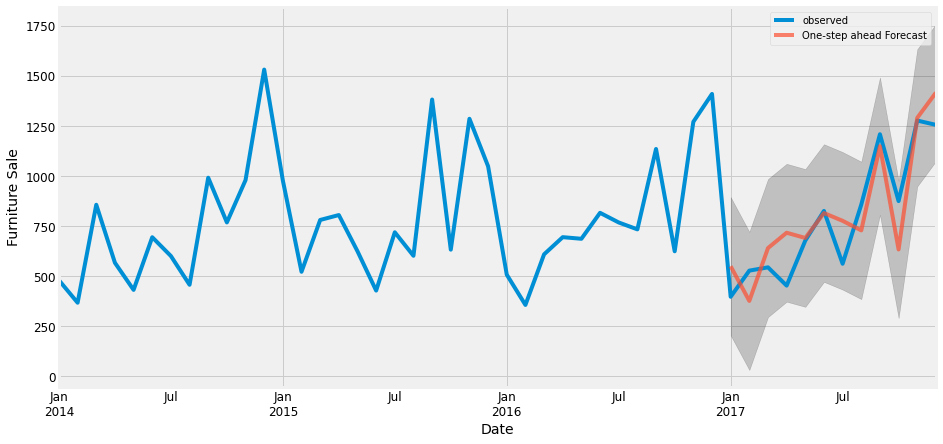

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14,7))

ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], 
                color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sale')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts aligne with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year. 

In [16]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.57


In [18]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse),2)))

The Root Mean Squared Error of our forecasts is 151.64


In statistics, the *mean squared error (MSE)* of an estimator measures the average of the squares of the errors--That is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator--it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.  
   
*Root Mean Squared Error (RMSE)* tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far. 

## ***Producing and Visualizing forecasts***

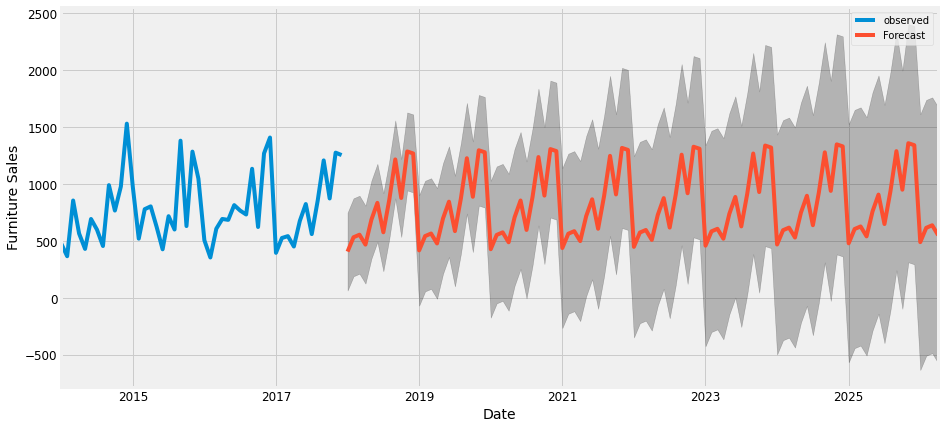

In [19]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize = (14,7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.  
   
The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other over time.  
Therefore, we are going to compare time series of furniture and office supplier.  


## ***Time Series of Furniture vs. Office Supplies***  
According to our data, there were way more number of sales from Office Supplies than from Furniture over the years  

In [20]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

## ***Data Exploration***  
We are going to compare two categories's sales in the same time period.  
This means combine two data frames into one and plot these two categories' time serie into one plot

In [21]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 
        'Customer ID', 'Customer Name', 'Segment', 'Country',
        'City', 'State', 'Postal Code', 'Region', 'Product ID',
        'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values("Order Date")
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date': y_furniture.index,
                          'Sales': y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 
                       'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales',
                      'Sales_y': 'office_sales'}, inplace = True)
store.head()




,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


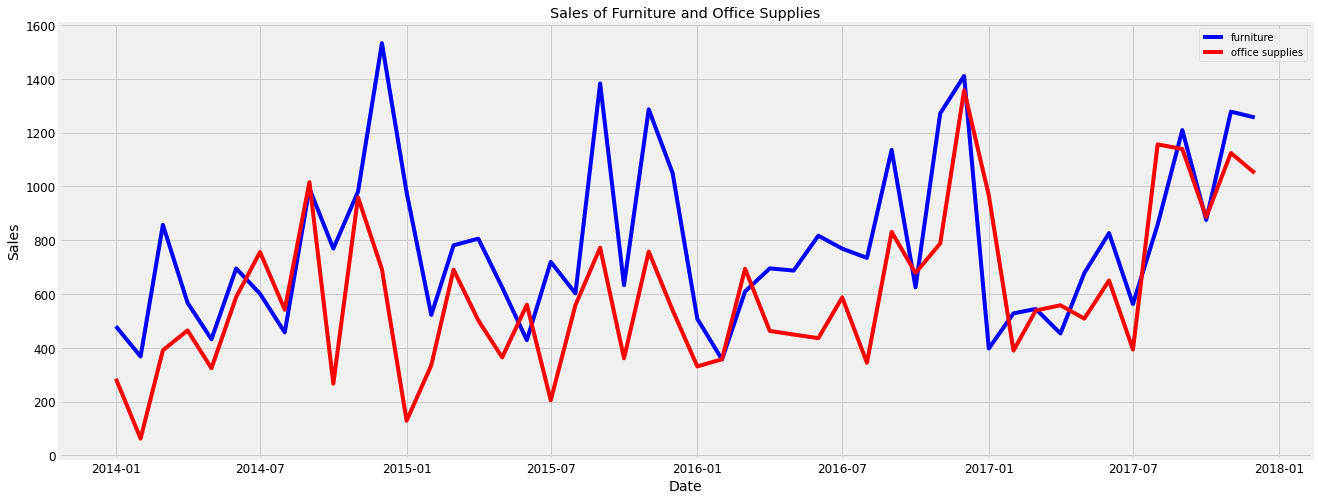

In [23]:
plt.figure(figsize=(20,8))
plt.plot(store['Order Date'], store['furniture_sales'],
         'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'],
         'r-', label = 'office supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of Furniture and Office Supplies')
plt.legend()
plt.show()

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. In addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies.  
Occasionally, office supplies passed furniture on average daily sales. Let's find out when was the first time office supplies' sales surpassed those of furnitures's

In [29]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))  

Office supplies first time produced higher sales than furniture is 2014-07-01.


It was July 2014!!

## ***Time Series Modeling with Prophet***  
Released by Facebook in 2017, forecasting tool *Proohet* is designed for analyzing time-series that display patterns of different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model un and running.  

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

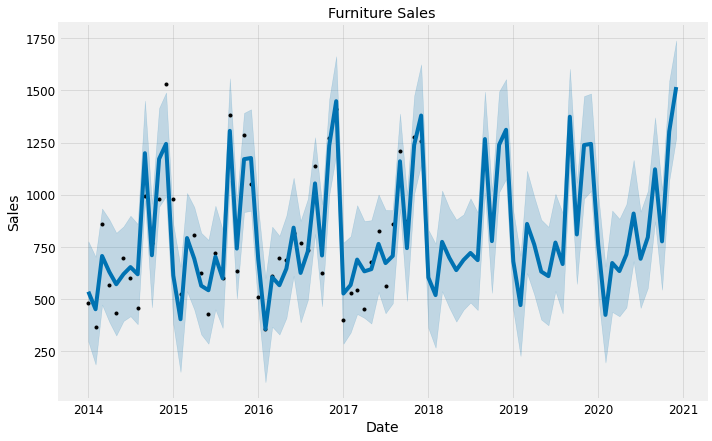

In [30]:
from fbprophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

furniture_forecast = furniture_model.make_future_dataframe(periods=36,freq = 'MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

plt.figure(figsize=(18,6))
furniture_model.plot(furniture_forecast, xlabel='Date', ylabel='Sales')
plt.title('Furniture Sales')
plt.show()

<Figure size 1296x432 with 0 Axes>

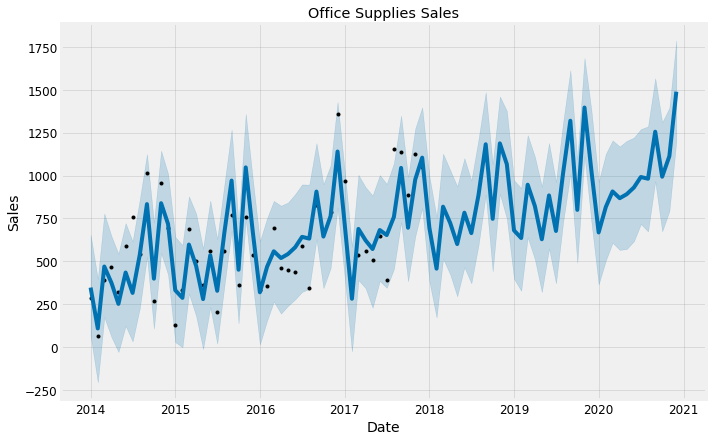

In [31]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales')
plt.show()

## ***Compare Forecasts***  
We already have the forcasts for three years for these two categories into the future. We will now join them together to compare their furture forecasts.

In [33]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how='inner', left_on='furniture_ds',
                    right_on = 'office_ds')

forecast = forecast.rename(columns = {'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,furniture_yearly_lower,furniture_yearly_upper,furniture_multiplicative_terms,furniture_multiplicative_terms_lower,furniture_multiplicative_terms_upper,furniture_yhat,office_trend,office_yhat_lower,office_yhat_upper,office_trend_lower,office_trend_upper,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,296.169355,776.177492,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,-190.685662,-190.685662,0.0,0.0,0.0,535.372051,487.530759,65.394473,654.559192,487.530759,487.530759,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,186.548879,702.589433,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,-276.377703,-276.377703,0.0,0.0,0.0,451.116320,494.918445,-203.873797,397.369922,494.918445,494.918445,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,473.177109,933.624040,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,-22.389755,-22.389755,0.0,0.0,0.0,706.401580,501.591193,175.016099,778.334920,501.591193,501.591193,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,390.738315,881.155050,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,-100.141158,-100.141158,0.0,0.0,0.0,630.086487,508.978878,59.128991,645.834194,508.978878,508.978878,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,325.395886,817.290522,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,-160.815662,-160.815662,0.0,0.0,0.0,570.801960,516.128251,-27.843426,544.383730,516.128251,516.128251,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


## ***Trend and Forecast Visualization***  


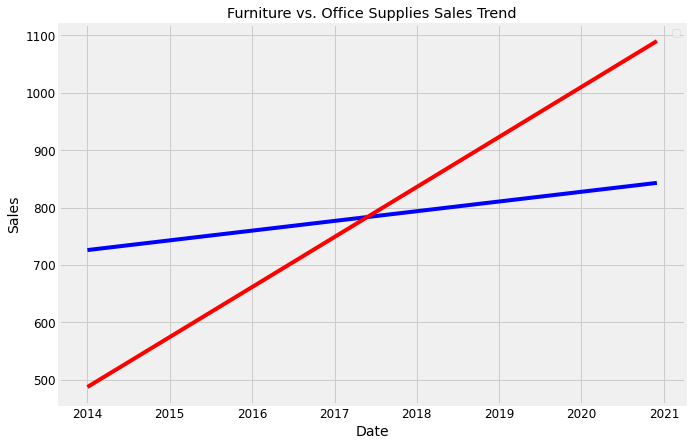

In [34]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend')
plt.show()

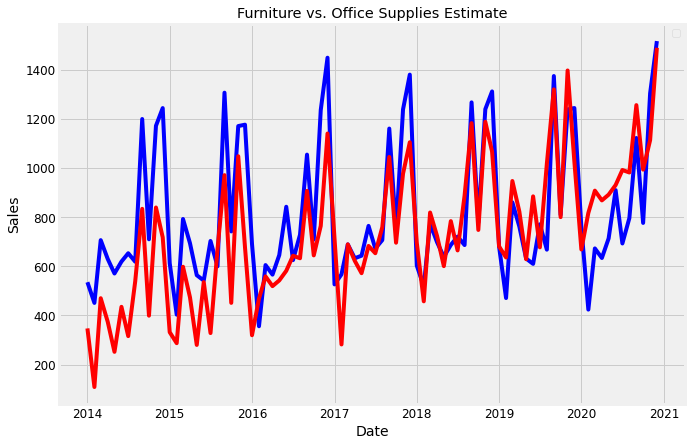

In [35]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

## ***Trend and Paterns***  
Now, we can use the *Prophet Models* to inspect different trends of these two categories in the data

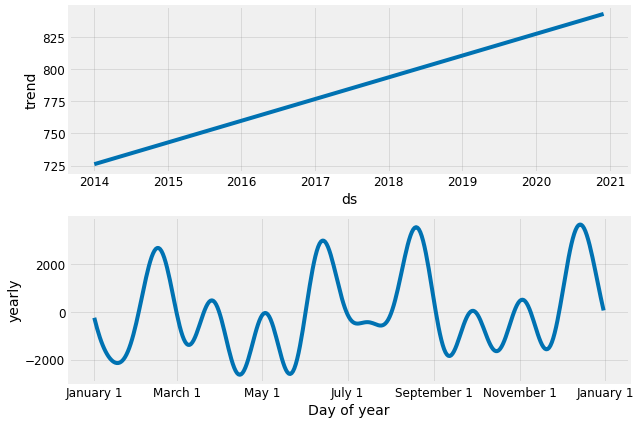

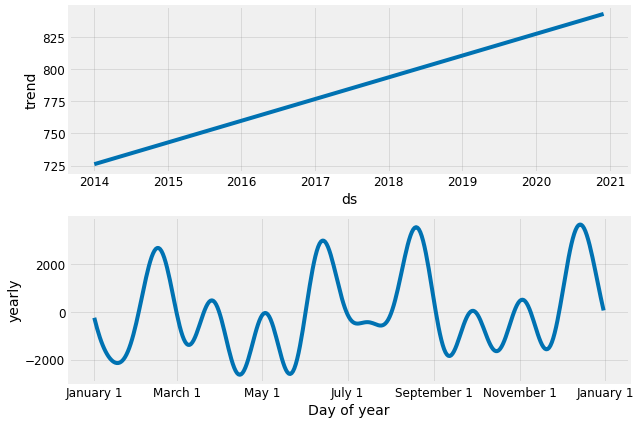

In [36]:
furniture_model.plot_components(furniture_forecast)

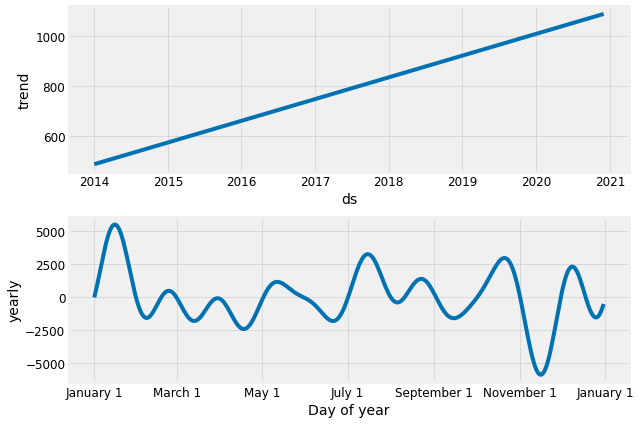

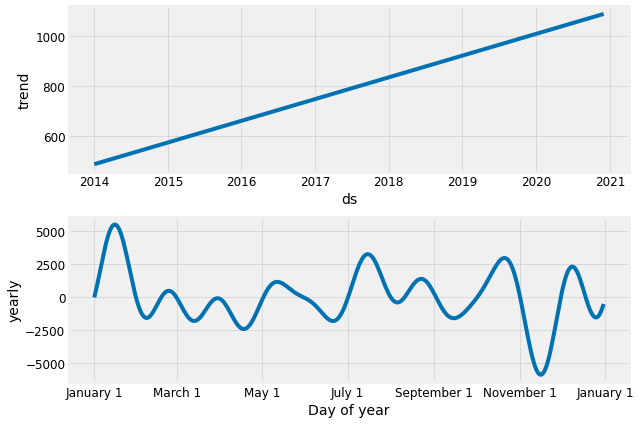

In [37]:
office_model.plot_components(office_forecast)

Good to see that the sales for both furniture and office supplies have been linearly increasing over time and will be keep growing, although office supplies' growth seems slightly stronger.  
  
The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is October.  
   
There are many time-series analysis we can explore from now on, such as forecast with uncertaintly bounds, change point and anomaly detection, forecast time-series with external data source. We have only just started.